In [3]:
import pandas as pd, numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.stats.mstats import winsorize
from sklearn.metrics import *
from sklearn.ensemble import RandomForestRegressor

In [4]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [5]:
train.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [6]:
train.shape, test.shape

((1460, 81), (1459, 80))

In [7]:
min(train["SalePrice"]), max(train["SalePrice"])

(34900, 755000)

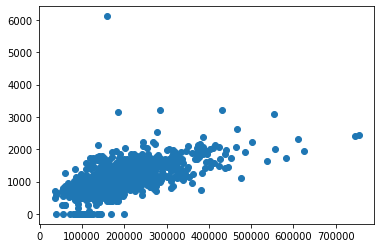

In [8]:
plt.scatter(train["SalePrice"], train["TotalBsmtSF"])
plt.show()

### Selecting only important variables and fitting Sale Price on these variables

In [9]:
variables = ["OverallQual", "MSSubClass","TotalBsmtSF","GrLivArea","SalePrice"]

In [10]:
train = train[variables]
Id = test["Id"]
test = test[["OverallQual", "MSSubClass","TotalBsmtSF","GrLivArea"]]

In [11]:
test.isna().sum() #Use isna() function to detect the missing values in a dataframe.

OverallQual    0
MSSubClass     0
TotalBsmtSF    1
GrLivArea      0
dtype: int64

In [15]:
min(test["TotalBsmtSF"])

0.0

In [16]:
test.fillna(0, inplace=True) #  Replacing NaN values with a Static value.

In [17]:
train.head(3)

,OverallQual,MSSubClass,TotalBsmtSF,GrLivArea,SalePrice
0,7,60,856,1710,208500
1,6,20,1262,1262,181500
2,7,60,920,1786,223500


### Transformation

In [18]:
y = train["SalePrice"]
x = train.drop(["SalePrice"], axis = 1)

In [19]:
y_log = np.log(y)
y_log

0       12.247694
1       12.109011
2       12.317167
3       11.849398
4       12.429216
          ...    
1455    12.072541
1456    12.254863
1457    12.493130
1458    11.864462
1459    11.901583
Name: SalePrice, Length: 1460, dtype: float64

In [20]:
y_win = winsorize(y, {0.025,0.95})
y_win

masked_array(data=[88000, 88000, 88000, ..., 88000, 88000, 88000],
             mask=False,
       fill_value=999999)

In [21]:
lr = LinearRegression()
lr.fit(x,y)
y_pred = lr.predict(test)
y_pred

array([117928.58386176, 182680.64817523, 150719.65491115, ...,
       145297.39191754, 112165.66718814, 229467.92920949])

In [22]:
lr = LinearRegression()
lr.fit(x,y_log)
y_pred_log = np.exp(lr.predict(test))
y_pred_log

array([121258.48168054, 167757.08285037, 140676.85556293, ...,
       137443.1031201 , 118122.3263278 , 213268.85875596])

In [23]:
lr = LinearRegression()
lr.fit(x,y_win)
y_pred_win = lr.predict(test)
y_pred_win

array([87284.02767614, 87693.08568658, 87440.08412641, ...,
       87412.76839305, 87290.59351484, 88010.94605463])

In [24]:
submit1 = pd.DataFrame({"Id":Id, "SalePrice": y_pred})
submit2 = pd.DataFrame({"Id":Id, "SalePrice": y_pred_log})
submit3 = pd.DataFrame({"Id":Id, "SalePrice": y_pred_win})

In [25]:
submit1.to_csv("submit1.csv", index=None)
submit2.to_csv("submit2.csv", index=None)
submit3.to_csv("submit3.csv", index=None)

In [26]:
ls

'9.1 - Distinction Between Outliers and High Leverage Observations _ STAT 462.pdf'
 Outlier-Impact-Treatment-master.zip
 outliers_detection.ipynb
 outliers_treatment_impact.ipynb
 submit1.csv
 submit2.csv
 submit3.csv
 test.csv
 train.csv


### Remove Outliers & Fit

#### IQR

In [27]:
q1 = np.percentile(train["SalePrice"],25)
q3 = np.percentile(train["SalePrice"],75)
iqr = q3-q1
upper = q3+1.5*iqr
lower = q1-1.5*iqr
lower, upper

(3937.5, 340037.5)

In [28]:
train_iqr = train[(train["SalePrice"]<upper) & (train["SalePrice"]>lower)]

In [29]:
train_iqr.shape

(1399, 5)

In [30]:
y = train_iqr["SalePrice"]
x = train_iqr.drop(["SalePrice"], axis = 1)
lr = LinearRegression()
lr.fit(x,y)
y_pred = lr.predict(test)

In [31]:
submit1 = pd.DataFrame({"Id":Id, "SalePrice": y_pred})
submit1.to_csv("submit_iqr.csv", index=None)

#### Z-Score
https://www.youtube.com/watch?time_continue=1&v=Gp4s5Ouk1gM

https://www.youtube.com/watch?v=5boLC40FpdQ

In [33]:
train = pd.read_csv("train.csv")
train = train[variables]
train

,OverallQual,MSSubClass,TotalBsmtSF,GrLivArea,SalePrice
0,7,60,856,1710,208500
1,6,20,1262,1262,181500
2,7,60,920,1786,223500
3,7,70,756,1717,140000
4,8,60,1145,2198,250000
...,...,...,...,...,...
1455,6,60,953,1647,175000
1456,6,20,1542,2073,210000
1457,7,70,1152,2340,266500
1458,5,20,1078,1078,142125


In [37]:
z = (train["SalePrice"] - np.mean(train["SalePrice"]))/np.std(train["SalePrice"])
train_z = train[(np.absolute(z)<2.5)]
train_z

,OverallQual,MSSubClass,TotalBsmtSF,GrLivArea,SalePrice
0,7,60,856,1710,208500
1,6,20,1262,1262,181500
2,7,60,920,1786,223500
3,7,70,756,1717,140000
4,8,60,1145,2198,250000
...,...,...,...,...,...
1455,6,60,953,1647,175000
1456,6,20,1542,2073,210000
1457,7,70,1152,2340,266500
1458,5,20,1078,1078,142125


In [38]:
y = train_z["SalePrice"]
x = train_z.drop(["SalePrice"], axis = 1)
lr = LinearRegression()
lr.fit(x,y)
y_pred = lr.predict(test)

In [39]:
submit1 = pd.DataFrame({"Id":Id, "SalePrice": y_pred})
submit1.to_csv("submit_z.csv", index=None)

### Random Forest

In [40]:
train = pd.read_csv("train.csv")
train = train[variables]

In [41]:
y = train["SalePrice"]
x = train.drop(["SalePrice"], axis = 1)
rf = RandomForestRegressor()
rf.fit(x,y)
y_pred = rf.predict(test)

/home/alinemati/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [42]:
submit1 = pd.DataFrame({"Id":Id, "SalePrice": y_pred})
submit1.to_csv("submit_rf_1.csv", index=None)

In [43]:
train_iqr = train[(train["SalePrice"]<upper) & (train["SalePrice"]>lower)]

In [44]:
y = train_iqr["SalePrice"]
x = train_iqr.drop(["SalePrice"], axis = 1)
rf.fit(x,y)
y_pred = rf.predict(test)

In [45]:
submit1 = pd.DataFrame({"Id":Id, "SalePrice": y_pred})
submit1.to_csv("submit_rf_iqr.csv", index=None)

In [46]:
y = train["SalePrice"]
x = train.drop(["SalePrice"], axis = 1)
y_log = np.log(y)
rf.fit(x,y_log)
y_pred_log = np.exp(rf.predict(test))

In [47]:
submit1 = pd.DataFrame({"Id":Id, "SalePrice": y_pred_log})
submit1.to_csv("submit_rf_log.csv", index=None)

In [48]:
y = train["SalePrice"]
x = train.drop(["SalePrice"], axis = 1)
rf = RandomForestRegressor(criterion='mae')
rf.fit(x,y)
y_pred = rf.predict(test)

/home/alinemati/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [49]:
submit1 = pd.DataFrame({"Id":Id, "SalePrice": y_pred})
submit1.to_csv("submit_rf_mae.csv", index=None)

In [50]:
y = train["SalePrice"]
x = train.drop(["SalePrice"], axis = 1)
y_win = winsorize(y, {0.025,0.95})
rf = RandomForestRegressor()
rf.fit(x,y_win)
y_pred = rf.predict(test)

/home/alinemati/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [51]:
submit1 = pd.DataFrame({"Id":Id, "SalePrice": y_pred})
submit1.to_csv("submit_rf_win.csv", index=None)